# IMPORT
In this section we clone our repository with all utils functions and classes and we import all the libraries

In [2]:
import shutil
shutil.rmtree('cultural_classification_nlp', ignore_errors=True)

!git clone "https://github.com/cybernetic-m/cultural_classification_nlp.git"
!pip install --quiet wikipedia wikidata datasets 2> /dev/null    # the 2> /dev/null redirects standard error to the null avoiding the print of dependencies conflicts

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

from cultural_classification_nlp.src.utils import  dict_save_and_load
from cultural_classification_nlp.dataset.CulturalDataset import CulturalDataset
from cultural_classification_nlp.models.LMClassifier import LMClassifier
from cultural_classification_nlp.training.train import train
from cultural_classification_nlp.testing.test import test


from datasets import load_dataset
from huggingface_hub import login
import pandas as pd
import json

# Plot import
import seaborn as sns
import matplotlib.pyplot as plt

# NN import
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import (
    AutoModel,
    AutoTokenizer,
    set_seed,
)

# Set a seed for reproducibility
seed = 42

torch.manual_seed(seed)  # CPU
torch.cuda.manual_seed(seed)  # Current GPU
torch.cuda.manual_seed_all(seed)  # All GPUs (if multi-GPU)
# Ensures deterministic behavior (at the cost of performance)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device ='cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Cloning into 'cultural_classification_nlp'...
remote: Enumerating objects: 602, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 602 (delta 64), reused 83 (delta 27), pack-reused 468 (from 1)
Receiving objects: 100% (602/602), 10.35 MiB | 13.62 MiB/s, done.
Resolving deltas: 100% (297/297), done.
Using cuda device


# Login to HuggingFace and Download dataset
- To download the dataset you need to have an HuggingFace account. Please create it: https://huggingface.co/
- You need to have a token: in this page https://huggingface.co/settings/tokens create a token called "notebooks" with "write" permissions. Then copy the key into the Token: cell!

In [3]:
login()

In [4]:
# Loading of the dataset from huggingface
dataset = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset')
# Print simple information about the dataset
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/946k [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/45.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6251 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['item', 'name', 'description', 'type', 'category', 'subcategory', 'label'],
        num_rows: 6251
    })
    validation: Dataset({
        features: ['item', 'name', 'description', 'type', 'category', 'subcategory', 'label'],
        num_rows: 300
    })
})

**Loading of the training hyperparameters**

**⚠️TAs Instructions⚠️**: If you want to test different hyperparams you can open the "Files" part of Colab and modify the config.json file!

As Transformer Encoder types you can try:

1. BERT Variants
----------------
- BERT-base: bert-base-uncased
- BERT-large: bert-large-uncased
- BERT-multilingual: bert-base-multilingual-cased
- BioBERT: dmis-lab/biobert-base-cased-v1.1
- SciBERT: allenai/scibert_scivocab_uncased

2. Distilled Models (Faster, Smaller)
-------------------------------------
- DistilBERT: distilbert-base-uncased
- DistilmBERT (Multilingual): distilbert-base-multilingual-cased
- MiniLM: nreimers/MiniLM-L6-H384-uncased

3. RoBERTa Variants
-------------------
- RoBERTa-base: roberta-base
- RoBERTa-large: roberta-large
- Twitter-RoBERTa: cardiffnlp/twitter-roberta-base-sentiment
- DeBERTa Base: microsoft/deberta-v3-base
- DeBERTa Large: microsoft/deberta-v3-large


4. Sentence Embedding Models
----------------------------
- SBERT (base): sentence-transformers/all-MiniLM-L6-v2
- SBERT (multilingual): sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
- SBERT (RoBERTa): sentence-transformers/all-roberta-large-v1

5. Other Strong Encoders
------------------------
- ALBERT: albert-base-v2
- ELECTRA: google/electra-base-discriminator
- MPNet: microsoft/mpnet-base
- XLNet: xlnet-base-cased

As pooling_type:

1. CLS Pooling => "cls"
2. Mean Pooling => "mean"
3. Max Pooling => "max"
4. Attention Pooling => "attention"

As text_type:

1. Name-Description => "ND"
2. Name-Description-Views => "NDV"
3. Name-Description-Views-Summary => "NDVS"

As classifier_type:

1. Linear => "linear"
2. MLP => "mlp"

In [5]:
config_path = './cultural_classification_nlp/config.json'

with open(config_path, 'r') as f:
  config = json.load(f)

batch_size = config['batch_size']
num_epochs = config['epochs']
learning_rate = config['lr']
language_model_name = config['language_model_name']
max_length = config['max_length']
text_type = config['text_type']
pooling_type = config['pooling_type']
classifier_type = config['classifier_type']

print(f"batch_size: {batch_size}")
print(f"num_epochs: {num_epochs}")
print(f"learning_rate: {learning_rate}")
print(f"language_model_name: {language_model_name}")
print(f"max_length: {max_length}")
print(f"text_type: {text_type}")
print(f"pooling_type: {pooling_type}")
print(f"classifier_type: {classifier_type}")

batch_size: 128
num_epochs: 5
learning_rate: 0.0001
language_model_name: bert-base-uncased
max_length: 64
text_type: ND
pooling_type: cls
classifier_type: linear


In [6]:
if text_type =='ND':
  train_df = pd.DataFrame(dataset['train'])
elif text_type == 'NDV' or 'NDVS':
  try:
    train_df = pd.read_csv('/content/drive/MyDrive/Caponata_Lovers_shared_folder/train_df_wikipedia.csv')
  except:
    train_df = pd.read_csv('./cultural_classification_nlp/wikipedia_data/train_df_wikipedia.csv')


print("Dimension of the training set:", len(train_df))
train_df.head()

Dimension of the training set: 6251


,item,name,description,type,category,subcategory,label
0,http://www.wikidata.org/entity/Q32786,916,2012 film by M. Mohanan,entity,films,film,cultural exclusive
1,http://www.wikidata.org/entity/Q371,!!!,American dance-punk band from California,entity,music,musical group,cultural representative
2,http://www.wikidata.org/entity/Q3729947,¡Soborno!,Mort & Phil comic,entity,comics and anime,comics,cultural representative
3,http://www.wikidata.org/entity/Q158611,+44,American band,entity,music,musical group,cultural representative
4,http://www.wikidata.org/entity/Q280375,1 Monk Street,"building in Monmouth, Wales",entity,architecture,building,cultural exclusive


In [7]:
if text_type =='ND':
  val_df = pd.DataFrame(dataset['validation'])
elif text_type == 'NDV' or 'NDVS':
  try:
    val_df = pd.read_csv('/content/drive/MyDrive/Caponata_Lovers_shared_folder/test_df_wikipedia.csv')
  except:
    val_df = pd.read_csv('./cultural_classification_nlp/wikipedia_data/test_df_wikipedia.csv')

print("Dimension of the validation set:", len(val_df))
val_df.head()

Dimension of the validation set: 300


,item,name,description,type,category,subcategory,label
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative


# LM-based approach Training

**Definition of the model**

Definition of the encoder model and tokenizer

To make them the same length in a batch, we use padding.
It also generates the attention mask to tell the model which tokens are real vs. padding.

Example 1:
"Unbelievable" => Tokenizer => ["un", "##believable"] (## means that is a continuation of the previous toke) => Token IDs => [101, 4895, 13745, 102]
101 is the [CLS] token and 102 is the [SEP] token (two special tokens)

Example 2:
Example of tokenization: ['pizza', 'is', 'my', 'love']
input_ids:tensor([[  101, 10733,  2003,  2026,  2293,   102,     0,     0,     0,     0]])
attention_mask:tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])


In [8]:
# Definition of the classifier
encoder = AutoModel.from_pretrained(language_model_name)
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

text = 'Pizza is my love'
tokens = tokenizer (
    text,
    max_length=10,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

print(f"Example of tokenization: {tokenizer.tokenize(text)}")
print(f"input_ids:{tokens['input_ids']}")
print(f"attention_mask:{tokens['attention_mask']}")

lm_classifier = LMClassifier(
    encoder=encoder,
    num_labels=3,
    mlp_list=[128],
    classifier_type=classifier_type,
    pooling=pooling_type
).to(device)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Example of tokenization: ['pizza', 'is', 'my', 'love']
input_ids:tensor([[  101, 10733,  2003,  2026,  2293,   102,     0,     0,     0,     0]])
attention_mask:tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])
Encoder type:

 BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): Be

**Dataset class and Dataloader**

In [9]:
# Training, Validation dataset classes
train_data = CulturalDataset(train_df, tokenizer, max_length, text_type, labels_flag = True)
val_data = CulturalDataset(val_df, tokenizer, max_length, text_type, labels_flag = True)

print(f"Training data dimension: {len(train_data)}")
print(f"Validation data dimension: {len(val_data)}")

# Dataloaders
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

Training data dimension: 6251
Validation data dimension: 300


In [10]:
print(train_data[1]['text'])

Name: !!!. Description: American dance-punk band from California


**Training**

In [11]:
# Definition of the optimizer and the loss function
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lm_classifier.parameters(), lr=learning_rate)

# Definition of the dictionaries for training and validation
train_metrics_dict  = {}
val_metrics_dict  = {}

train(
    num_epochs=num_epochs,
    model=lm_classifier,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    train_metrics_dict=train_metrics_dict,
    val_metrics_dict=val_metrics_dict,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device,
    config_dict = config
)


EPOCH 1/5:


TRAIN:
loss:32.50084576010704  accuracy: 0.6986082226843705  precision:0.7001258126783539  recall:0.6739119060492437  f1-score: 0.6794809424390921


VALIDATION:
loss: 1.8296503722667694  accuracy: 0.7466666666666667  precision:0.7229485627318445  recall:0.7223718193959217  f1-score: 0.7204721323265013
Model saved!

EPOCH 2/5:


TRAIN:
loss:18.098127737641335  accuracy: 0.8523436250199968  precision:0.8476047158632602  recall:0.8445217088968376  f1-score: 0.8455089502792602


VALIDATION:
loss: 2.242398977279663  accuracy: 0.77  precision:0.7575231481481483  recall:0.7487895591683098  f1-score: 0.7509254864736592

EPOCH 3/5:


TRAIN:
loss:11.10767375677824  accuracy: 0.9168133098704208  precision:0.9146228477396917  recall:0.9130336450035607  f1-score: 0.9137340542800044


VALIDATION:
loss: 2.9557912349700928  accuracy: 0.7333333333333333  precision:0.7226829062935742  recall:0.723804028403143  f1-score: 0.722732093453793

EPOCH 4/5:


TRAIN:
loss:8.19263805821538  accuracy: 0.9337705967045272  precision:0.9314546638337351  recall:0.932504228300643  f1-score: 0.9319483873777584


VALIDATION:
loss: 3.8893141746520996  accuracy: 0.7133333333333334  precision:0.7254201349763125  recall:0.7179644834588267  f1-score: 0.6890759446315001

EPOCH 5/5:


TRAIN:
loss:5.65880180336535  accuracy: 0.9632058870580708  precision:0.9620631193476759  recall:0.9622141310658723  f1-score: 0.9621380490498052


VALIDATION:
loss: 3.205948293209076  accuracy: 0.7333333333333333  precision:0.7197574734198503  recall:0.7242153330446492  f1-score: 0.715672560333803


# VALIDATION

**⚠️TAs Instructions⚠️**:

You should change "model_path" variable putting the path of the trained model

 (Ex. '/content/training_2025-05-02_16-38/best_model.pt')

Test Metrics:
test loss: 0.6098834574222565
accuracy: 0.7466666666666667  precision: 0.7229485627318445  recall: 0.7223718193959217  f1_score: 0.7204721323265013
Confusion Matrix:


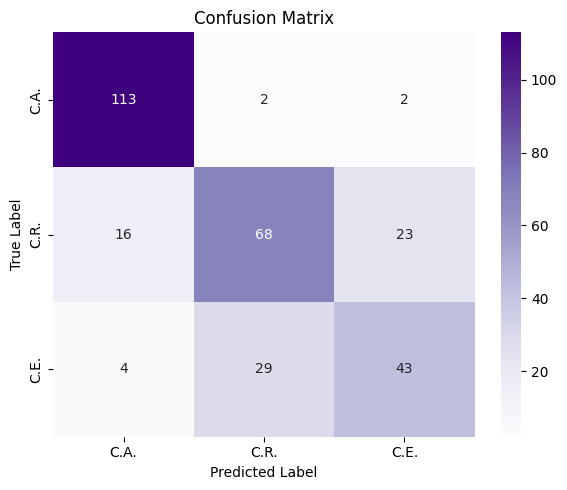

In [12]:
# Copy in the next line the model.pt path
model_path = '/content/training_2025-05-04_15-33/best_model.pt'

# Definition of the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Definition of the test metric dictionary
test_metrics_dict  = {}

test(
    model=lm_classifier,
    model_path=model_path,
    test_dataloader=val_dataloader,
    test_metrics_dict=test_metrics_dict,
    loss_fn=loss_fn,
    device=device
)
